In [1]:
import pandas as pd
import numpy as np

fs = 256  # Hz
path = "../data/processed/sub-02/tables/merged_annotated_with_audio.csv"

df = pd.read_csv(path)

# Make sure time_s exists
if "time_s" not in df.columns:
    df["time_s"] = np.arange(len(df)) / fs

print(df.columns)
print(df[["time_s", "respiration", "env_broad", "env_swell_0p3hz"]].head())
print("Duration (s):", df["time_s"].iloc[-1])


C:\Users\andre\AppData\Local\Temp\ipykernel_36608\2116858031.py:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Index(['ecg', 'respiration', 'physio_triggers', 'condition_triggers',
       'sequence', 'battery', 'flags', 'EEG-ch1', 'EEG-ch2', 'EEG-ch3',
       'EEG-ch4', 'EEG-ch5', 'EEG-ch6', 'EEG-ch7', 'EEG-ch8', 'EEG-ch9',
       'EEG-ch10', 'EEG-ch11', 'EEG-ch12', 'EEG-ch13', 'EEG-ch14', 'EEG-ch15',
       'EEG-ch16', 'EEG-ch17', 'EEG-ch18', 'EEG-ch19', 'EEG-ch20', 'EEG-ch21',
       'EEG-ch22', 'EEG-ch23', 'EEG-ch24', 'EEG-ch25', 'EEG-ch26', 'EEG-ch27',
       'EEG-ch28', 'EEG-ch29', 'EEG-ch30', 'EEG-ch31', 'EEG-ch32',
       'eeg_triggers', 'condition_names', 'time_s', 'env_broad',
       'env_swell_0p3hz', 'env_swell_0p1hz', 'env_mid_1_5hz'],
      dtype='object')
     time_s   respiration  env_broad  env_swell_0p3hz
0  0.000000  52500.224304        NaN         0.000000
1  0.003906  52066.183090        NaN         0.010852
2  0.007812  52077.127934        NaN         0.021063
3  0.011719  52087.760067        NaN         0.030703
4  0.015625  52080.255032        NaN         0.039832
Duratio

In [2]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

# 1. Get interpolated respiration
resp_interp = df["respiration"].interpolate(method="linear")

# 2. Center
resp_centered = resp_interp - resp_interp.mean()

# 3. Scale before filtering (important!)
resp_scaled = resp_centered / np.max(np.abs(resp_centered))

# 4. Bandpass filter (filtfilt with direct-form coefficients was numerically 
# unstable at very low cutoff frequencies on a long signal.
# Switching to second-order sections (sosfiltfilt) fixed it because SOS form is numerically stable.)

def bandpass_sos(x, fs, lo=0.05, hi=1.0, order=4):
    nyq = fs / 2
    sos = butter(order, [lo/nyq, hi/nyq], btype="band", output="sos")
    return sosfiltfilt(sos, x)

resp_filt = bandpass_sos(resp_scaled, fs=256)

# 5. Z-score normalize
resp_clean = (resp_filt - np.mean(resp_filt)) / np.std(resp_filt)

# 6. Store in dataframe
df["respiration_clean"] = resp_clean

print("Remaining NaNs:", df["respiration_clean"].isna().sum())
print(df["respiration_clean"].head())


Remaining NaNs: 0
0   -0.369207
1   -0.389378
2   -0.409509
3   -0.429593
4   -0.449625
Name: respiration_clean, dtype: float64


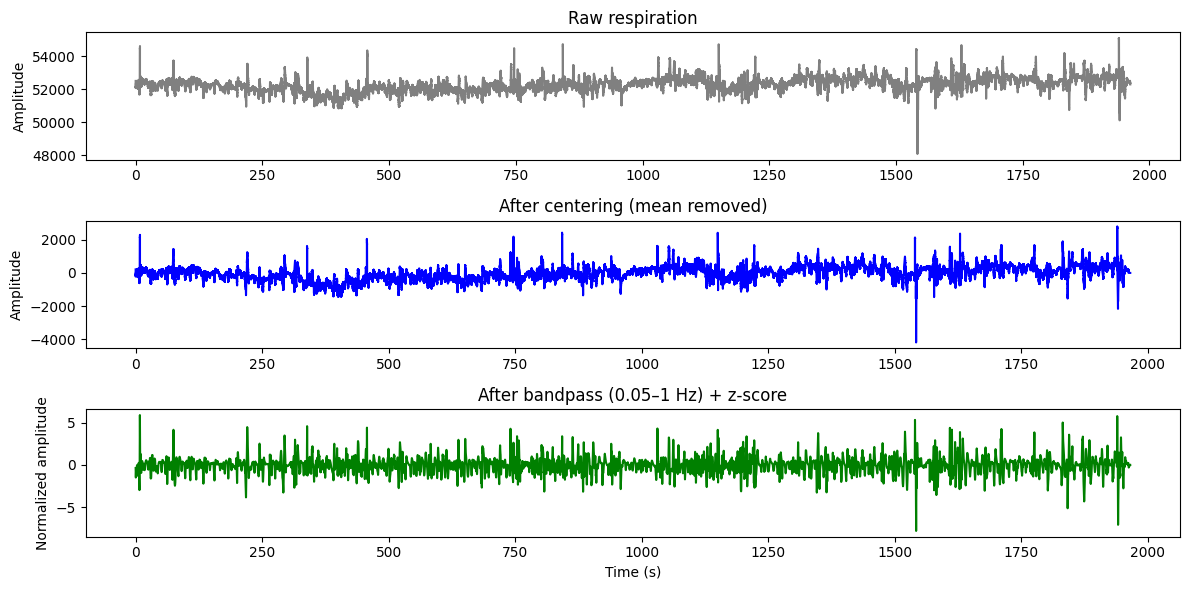

In [9]:
from matplotlib import pyplot as plt
# Plot first 120 seconds for clarity
t = df["time_s"].to_numpy()

plt.figure(figsize=(12,6))

plt.subplot(3,1,1)
plt.plot(t, df["respiration"], color="gray")
plt.title("Raw respiration")
plt.ylabel("Amplitude")

plt.subplot(3,1,2)
plt.plot(t, resp_centered, color="blue")
plt.title("After centering (mean removed)")
plt.ylabel("Amplitude")

plt.subplot(3,1,3)
plt.plot(t, resp_clean, color="green")
plt.title("After bandpass (0.05–1 Hz) + z-score")
plt.xlabel("Time (s)")
plt.ylabel("Normalized amplitude")

plt.tight_layout()
plt.show()


Synchronisation


In [3]:
def pair_segments(indices_dict):
    """
    Transform output of utils.get_condition_segments into 
    {condition: (start_idx, stop_idx)} pairs.
    """
    segments = {}
    for key, val in indices_dict.items():
        if isinstance(key, str) and key.endswith("_start"):
            base = key.replace("_start", "")
            stop_key = base + "_stop"
            if stop_key in indices_dict and indices_dict[stop_key] is not None:
                segments[base] = (val, indices_dict[stop_key])
    return segments


In [4]:
from HNA.modules.utils import get_condition_segments

indices = get_condition_segments(df, df["condition_names"].unique())
segments = pair_segments(indices)

print("Indices:", indices)
print("Segments:", segments)


Indices: {'AUDIO_SYNC': 0, '0': 1, 'RS1_start': 2202, 0: 16384, 'RS1_stop': 86802, 'MULTI_start': 117079, 'MULTI_stop': 191161, 'AUD_start': 215800, 'AUD_stop': 294554, 'VIZ_start': 312995, 'VIZ_stop': 394328, 'RS2_start': 417080, 'RS2_stop': 496660}
Segments: {'RS1': (2202, 86802), 'MULTI': (117079, 191161), 'AUD': (215800, 294554), 'VIZ': (312995, 394328), 'RS2': (417080, 496660)}


In [20]:
import numpy as np
import pandas as pd
from HNA.modules.coupling import windowed_xcorr, band_coherence, plv_phase_sync, windowed_plv, wpli_phase_sync, windowed_wpli

fs = 256

# store results in nested dict
sync_results = {}

for cond, (start, stop) in segments.items():
    sync_results[cond] = {}
    r = df.loc[start:stop]
    resp_ = r["respiration_clean"].to_numpy()
    swell_ = r["env_swell_0p3hz"].to_numpy()


    # --- run synchrony metrics ---
    xc = windowed_xcorr(resp_, swell_, fs=fs, win_sec=120, step_sec=10, max_lag_sec=10)
    coh = band_coherence(resp_, swell_, fs=fs, fmin=0.05, fmax=0.5)
    plv = plv_phase_sync(resp_, swell_, fs=fs)
    win_plv = windowed_plv(resp_, swell_, fs=fs, win_sec=120, step_sec=10)
    wpli_global = wpli_phase_sync(resp_, swell_, fs=fs)                     # single value
    wpli_win    = windowed_wpli(resp_, swell_, fs=fs, win_sec=30, step_sec=1)  # time series
    

    # --- collect results ---
    sync_results[cond]= {
        "xcorr_peak_mean": float(np.mean(xc.peak_r)),
        'xcorr_dist': xc.peak_r,
        "xcorr_peak_lag_mean": float(np.mean(xc.peak_lag_s)),
        "coh_band_avg": coh.band_avg_coh,
        "coh_peak": coh.peak_coh,
        "plv": plv.plv,
        "preferred_lag_s": plv.preferred_lag_s,
        "dom_freq": plv.f0,
        "wpli": wpli_global.wpli,
        "wpli_band": wpli_global.band,
        "wpli_win": wpli_win,  # dict: {"times_s": ..., "wpli": ...}
    }

# convert nested dict → multi-index dataframe
# sync_df = (
#     pd.DataFrame(sync_results)
#     .T.stack()  # conditions × envelopes × metrics
#     .unstack(level=1)  # multi-index: (condition, envelope)
# )

# print(sync_df)


c:\Users\andre\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1668: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


In [6]:
sync_results['AUD']

{'xcorr_peak_mean': 0.22686831961457177,
 'xcorr_dist': array([0.16820261, 0.16361919, 0.11920188, 0.14927861, 0.17000499,
        0.16395535, 0.14114761, 0.2586715 , 0.18248239, 0.2229739 ,
        0.22664278, 0.29738857, 0.28169088, 0.31897749, 0.27995016,
        0.29866126, 0.31042267, 0.29381834, 0.26340791]),
 'xcorr_peak_lag_mean': 0.5162417763157895,
 'coh_band_avg': 1.0,
 'coh_peak': 1.0000000000000007,
 'plv': 0.13127988736938268,
 'preferred_lag_s': -5.34405545330486,
 'dom_freq': 0.08,
 'wpli': 0.09737207893976851,
 'wpli_band': (0.020000000000000004, 0.14),
 'wpli_win': {'times_s': array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 150., 160.,
         170., 180., 190., 200., 210., 220., 230., 240.]),
  'wpli': array([0.17933302, 0.25048869, 0.02573089, 0.00422645, 0.04129537,
         0.22182012, 0.05787956, 0.1524651 , 0.04982204, 0.02160242,
         0.01936444, 0.1385727 , 0.25743368, 0.17784801, 0.23038234,
         0.20464591, 0.3977626 , 0.24031077, 0.2448

In [23]:
import numpy as np
from scipy import signal
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

# --- reuse your helpers ---
from HNA.modules.coupling import _nan_interp, _butter_bandpass, _wpli_from_phase

def _butter_bandpass(lo, hi, fs, order=4):
    nyq = fs * 0.5
    lo = max(1e-6, lo/nyq)
    hi = min(0.99,   hi/nyq)
    sos = signal.butter(order, [lo, hi], btype='bandpass', output='sos')
    return sos

def _wpli_from_phase(dphi: np.ndarray) -> float:
    s = np.sin(dphi.astype(float))
    den = np.mean(np.abs(s)) + 1e-12
    num = np.abs(np.mean(s))
    return float(num / den) if den > 0 and np.isfinite(den) else np.nan

# ---------- GLOBAL wPLI over several bands ----------
def wpli_multiband(
    s1: np.ndarray,
    s2: np.ndarray,
    fs: float,
    bands: List[Tuple[float, float]],
    order: int = 4
) -> Dict[str, float]:
    """
    Returns {'lo-hi': wpli_scalar, ...} for each band in Hz.
    """
    s1 = _nan_interp(np.asarray(s1, float))
    s2 = _nan_interp(np.asarray(s2, float))
    out = {}
    for (lo, hi) in bands:
        sos = _butter_bandpass(lo, hi, fs, order=order)
        x1 = signal.sosfiltfilt(sos, s1)
        x2 = signal.sosfiltfilt(sos, s2)
        phi1 = np.angle(signal.hilbert(x1))
        phi2 = np.angle(signal.hilbert(x2))
        dphi = np.angle(np.exp(1j * (phi1 - phi2)))
        out[f"{lo:.3f}-{hi:.3f}"] = _wpli_from_phase(dphi)
    return out

# ---------- WINDOWED wPLI over several bands ----------
def windowed_wpli_multiband(
    s1: np.ndarray,
    s2: np.ndarray,
    fs: float,
    bands: List[Tuple[float, float]],
    win_sec: float = 120.0,
    step_sec: float = 10.0,
    order: int = 4
) -> Dict[str, np.ndarray]:
    """
    Returns dict with:
      - 'times_s': 1D array of window centers
      - one key per band label 'lo-hi' -> 1D array (wPLI per window)
    """
    s1 = _nan_interp(np.asarray(s1, float))
    s2 = _nan_interp(np.asarray(s2, float))

    W = int(round(win_sec * fs))
    H = int(round(step_sec * fs))
    if W <= 1 or W > len(s1):
        raise ValueError("Window size must be >1 and <= length of signals.")
    starts = np.arange(0, len(s1) - W + 1, H)

    # prebuild filters per band
    band_labels = [f"{lo:.3f}-{hi:.3f}" for (lo, hi) in bands]
    sos_bank = {lbl: _butter_bandpass(lo, hi, fs, order=order) for lbl, (lo, hi) in zip(band_labels, bands)}

    # init outputs
    out = {lbl: [] for lbl in band_labels}
    times = []

    for st in starts:
        seg1 = s1[st:st+W]
        seg2 = s2[st:st+W]
        times.append((st + W/2) / fs)

        for lbl, sos in sos_bank.items():
            x1 = signal.sosfiltfilt(sos, seg1)
            x2 = signal.sosfiltfilt(sos, seg2)
            phi1 = np.angle(signal.hilbert(x1))
            phi2 = np.angle(signal.hilbert(x2))
            dphi = np.angle(np.exp(1j * (phi1 - phi2)))
            out[lbl].append(_wpli_from_phase(dphi))

    out["times_s"] = np.asarray(times)
    for lbl in band_labels:
        out[lbl] = np.asarray(out[lbl])
    return out


In [24]:


# choose bands — example for slow waves/resp ranges (adjust to your needs)
bands = [(0.05,0.10), (0.10,0.15), (0.15,0.20), (0.20,0.30), (0.30,0.50)]

for cond, (start, stop) in segments.items():
    r = df.loc[start:stop]
    resp_  = r["respiration_clean"].to_numpy()
    swell_ = r["env_swell_0p3hz"].to_numpy()

    # global
    wpli_bands_global = wpli_multiband(resp_, swell_, fs=fs, bands=bands)

    # windowed
    wpli_bands_win = windowed_wpli_multiband(
        resp_, swell_, fs=fs, bands=bands,
        win_sec=120, step_sec=10
    )

    # store
    sync_results.setdefault(cond, {})
    sync_results[cond]["wpli_bands_global"] = wpli_bands_global              # dict: band_label -> scalar
    sync_results[cond]["wpli_bands_win"]    = wpli_bands_win                 # dict: 'times_s' + band_label -> 1D



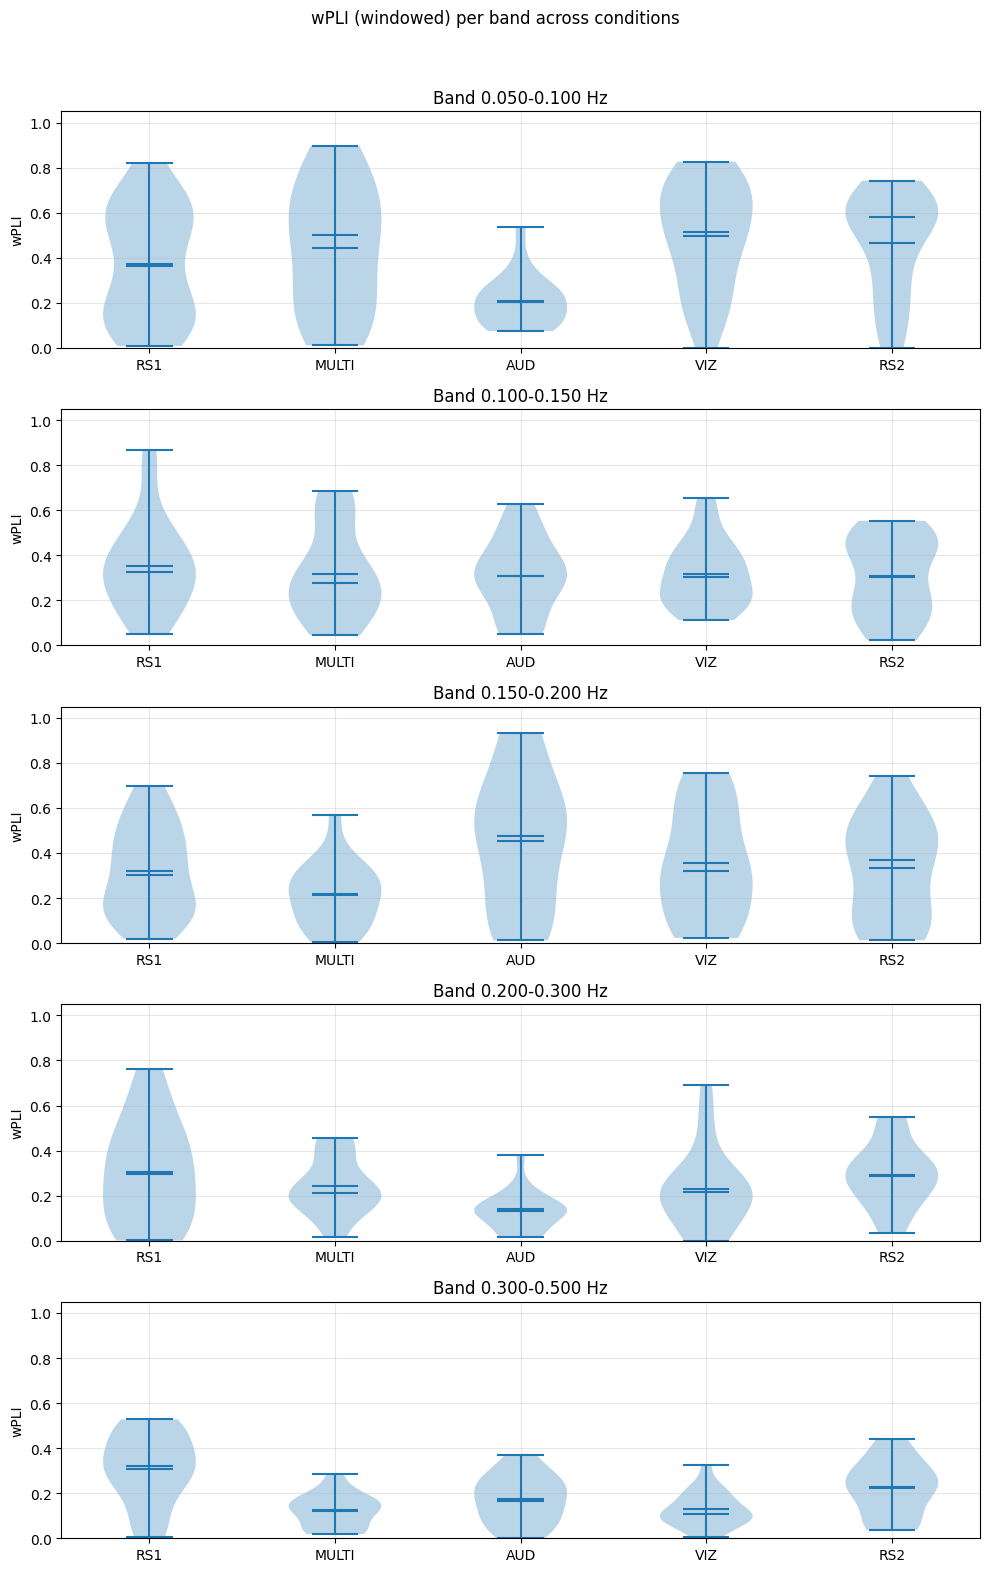

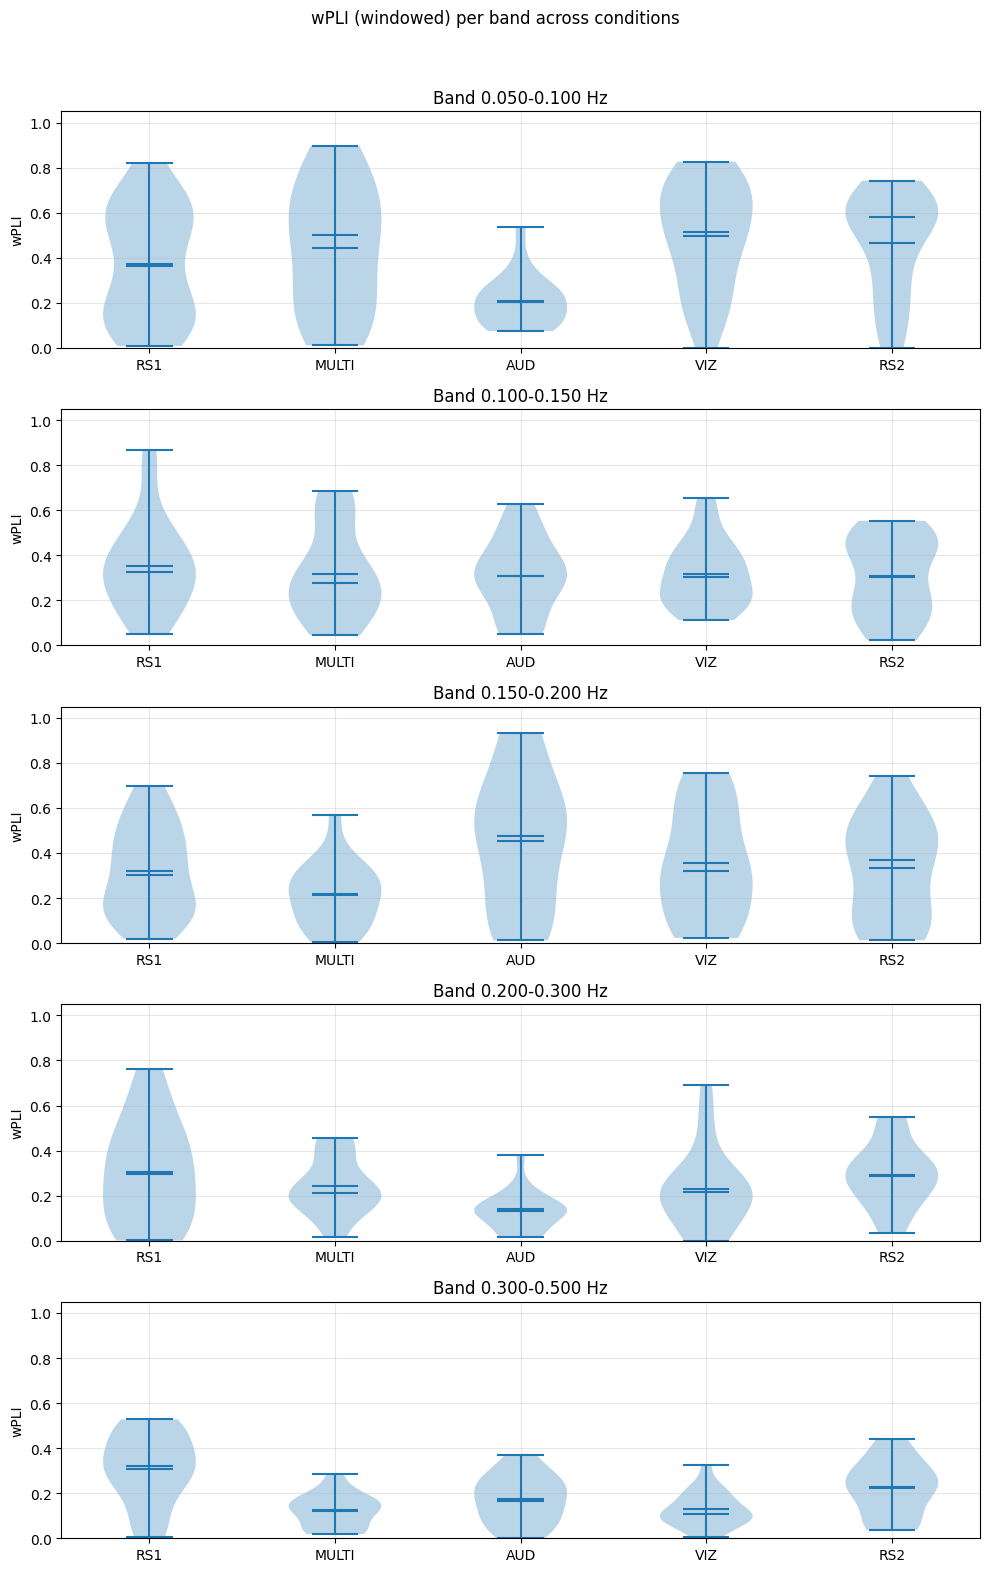

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def violin_wpli_bands(sync_results, band_labels=None, title="wPLI (windowed) per band across conditions", savepath=None):
    """
    One violin per condition *per band* (panel per band).
    If band_labels is None, infer from first condition's 'wpli_bands_win'.
    """
    if not sync_results:
        raise ValueError("sync_results is empty.")

    any_cond = next(iter(sync_results))
    win_dict = sync_results[any_cond].get("wpli_bands_win", {})
    if band_labels is None:
        band_labels = [k for k in win_dict.keys() if k != "times_s"]

    n_bands = len(band_labels)
    fig, axes = plt.subplots(n_bands, 1, figsize=(10, 3.2*n_bands), squeeze=False)
    axes = axes.ravel()

    for i, band in enumerate(band_labels):
        labels = []
        data = []
        for cond, res in sync_results.items():
            wdict = res.get("wpli_bands_win", {})
            arr = wdict.get(band, None)
            if arr is None: 
                continue
            arr = np.asarray(arr, float)
            arr = arr[np.isfinite(arr)]
            if arr.size == 0:
                continue
            labels.append(cond)
            data.append(arr)
        ax = axes[i]
        if not data:
            ax.text(0.5, 0.5, f"No data for band {band}", ha="center", va="center")
            ax.axis("off"); continue
        parts = ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True)
        ax.set_xticks(np.arange(1, len(labels)+1))
        ax.set_xticklabels(labels, rotation=0)
        ax.set_ylim(0, 1.05)
        ax.set_ylabel("wPLI")
        ax.set_title(f"Band {band} Hz")
        ax.grid(True, alpha=0.3)

    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160)
    return fig

def bar_wpli_bands_global(sync_results, cond, title=None, savepath=None):
    d = sync_results[cond].get("wpli_bands_global", {})
    if not d:
        raise ValueError(f"No 'wpli_bands_global' for {cond}")
    bands = list(d.keys())
    vals  = [d[b] for b in bands]
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(np.arange(len(bands)), vals)
    ax.set_xticks(np.arange(len(bands)))
    ax.set_xticklabels(bands, rotation=0)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("wPLI (global)")
    ax.set_title(title or f"Global wPLI per band — {cond}")
    ax.grid(True, axis="y", alpha=0.3)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=160)
    return fig

# After filling sync_results:
violin_wpli_bands(sync_results)                 # windowed distributions per band (panels)
# bar_wpli_bands_global(sync_results, cond="MULTI") # global per band for a single condition


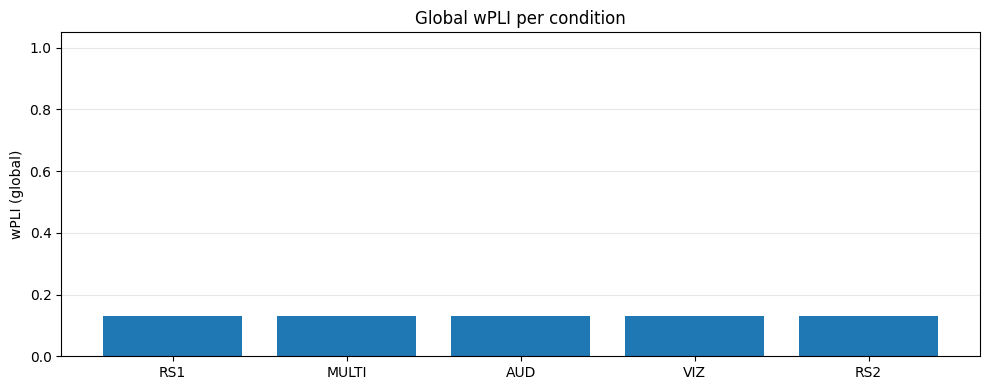

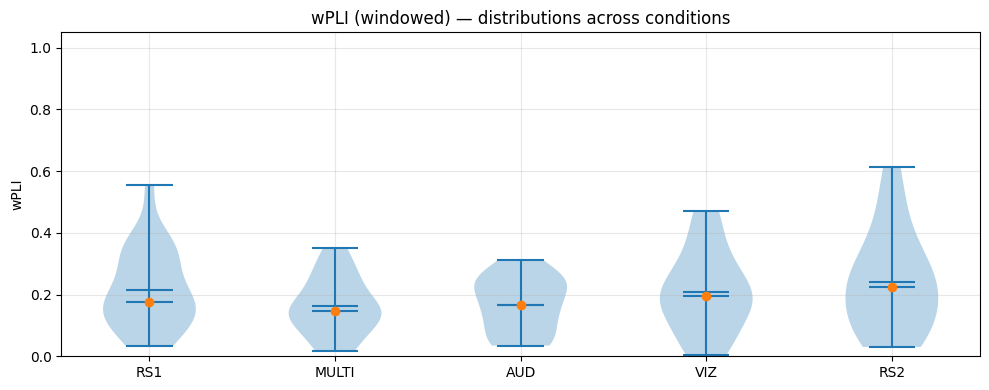

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def _clean(arr):
    a = np.asarray(arr, float)
    return a[np.isfinite(a)]

def _violin(ax, data_dict, ylabel, title):
    """data_dict: {cond: 1D array}"""
    labels = list(data_dict.keys())
    data = [ _clean(v) for v in data_dict.values() ]
    parts = ax.violinplot(data, showmeans=True, showextrema=True, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    return parts

# ---- XCORR: peak r distribution per condition ----
def violin_xcorr_peak(sync_results, savepath=None):
    data = {}
    for cond, res in sync_results.items():
        data[cond] = res["xc"].peak_r
    fig, ax = plt.subplots(figsize=(10,4))
    _violin(ax, data, ylabel="XCorr peak r", title="XCorr peak r — distributions across conditions")
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=160)
    return fig

# ---- XCORR: peak lag distribution per condition ----
def violin_xcorr_lag(sync_results, savepath=None):
    data = {}
    for cond, res in sync_results.items():
        data[cond] = res["xc"].peak_lag_s
    fig, ax = plt.subplots(figsize=(10,4))
    _violin(ax, data, ylabel="XCorr peak lag (s)", title="XCorr peak lag — distributions across conditions")
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=160)
    return fig

# ---- Coherence: windowed band-average per condition ----
def violin_coh_bandavg(sync_results, savepath=None):
    data = {}
    for cond, res in sync_results.items():
        coh = res["coh"]
        y = coh.get("band_avg_coh_win", None)
        if y is not None: data[cond] = y
    fig, ax = plt.subplots(figsize=(10,4))
    _violin(ax, data, ylabel="Band-avg coherence", title="Band-avg coherence — distributions across conditions")
    ax.set_ylim(0, 1.05)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=160)
    return fig

# ---- PLV: windowed PLV per condition ----
def violin_plv(sync_results, savepath=None):
    data = {}
    for cond, res in sync_results.items():
        data[cond] = res["plv"]["plv"]
    fig, ax = plt.subplots(figsize=(10,4))
    _violin(ax, data, ylabel="PLV", title="PLV — distributions across conditions")
    ax.set_ylim(0, 1.05)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=160)
    return fig

# ---- PLV: preferred lag per condition ----
def violin_plv_lag(sync_results, savepath=None):
    data = {}
    for cond, res in sync_results.items():
        data[cond] = res["plv"]["preferred_lag_s"]
    fig, ax = plt.subplots(figsize=(10,4))
    _violin(ax, data, ylabel="PLV-derived preferred lag (s)", title="PLV-derived preferred lag — distributions across conditions")
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=160)
    return fig


import numpy as np
import matplotlib.pyplot as plt

def _clean(a):
    a = np.asarray(a, float)
    return a[np.isfinite(a)]

def violin_wpli(sync_results, title="wPLI (windowed) — distributions across conditions", savepath=None):
    """
    Build a violin plot of windowed wPLI per condition.
    Expects sync_results[cond]["wpli_win"]["wpli"] = 1D array over windows.
    """
    labels = []
    data = []
    for cond, res in sync_results.items():
        w = res.get("wpli_win", {}).get("wpli", None)
        if w is None:
            continue
        w = _clean(w)
        if w.size == 0:
            continue
        labels.append(cond)
        data.append(w)

    if not data:
        raise ValueError("No windowed wPLI arrays found in sync_results.")

    fig, ax = plt.subplots(figsize=(10, 4))
    parts = ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True)

    # x ticks / labels
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=0)

    # y range (wPLI in [0,1])
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("wPLI")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # optional: overlay per-condition medians as points for quick reading
    meds = [float(np.median(d)) for d in data]
    ax.plot(np.arange(1, len(labels) + 1), meds, "o")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=160)
    return fig

def bar_wpli_global(sync_results, title="Global wPLI per condition", savepath=None):
    labels, vals = [], []
    for cond, res in sync_results.items():
        v = res.get("wpli", None)  # scalar
        if v is None or not np.isfinite(v):
            continue
        labels.append(cond)
        vals.append(float(v))

    if not vals:
        raise ValueError("No global wPLI values found in sync_results.")

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(labels)), vals)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("wPLI (global)")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=160)
    return fig

# Example:
fig = bar_wpli_global(sync_results)
plt.show()

# Example:
fig = violin_wpli(sync_results)
plt.show()


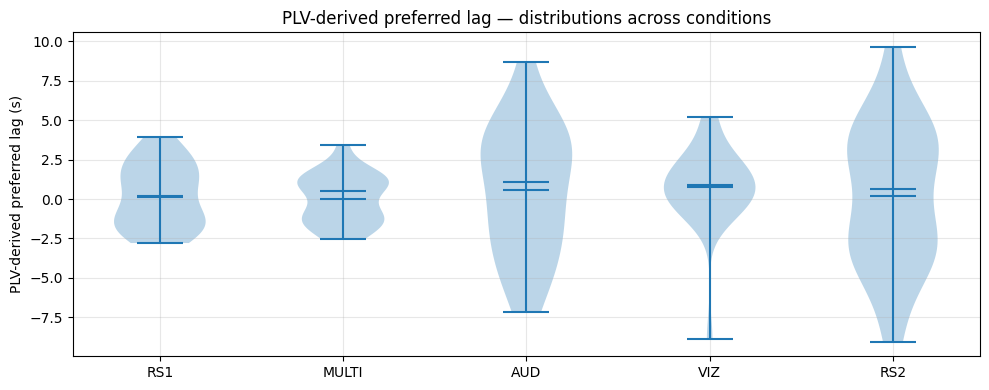

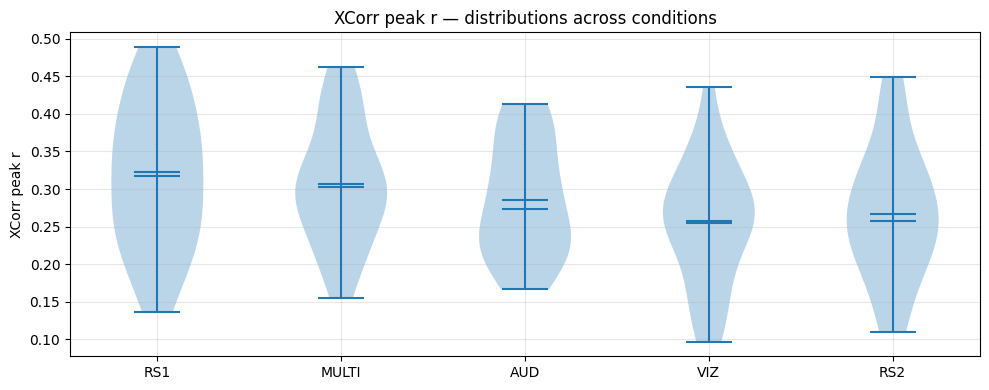

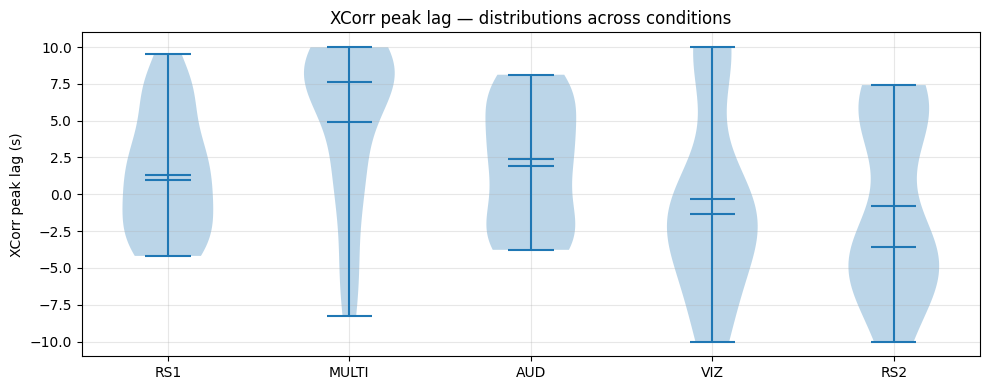

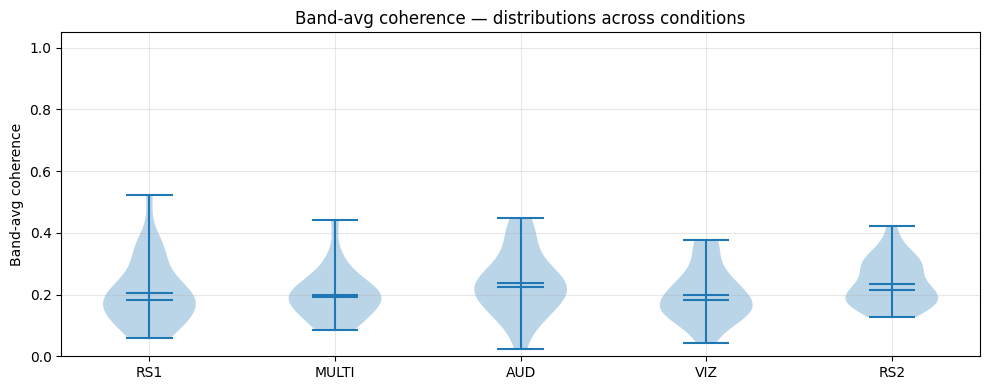

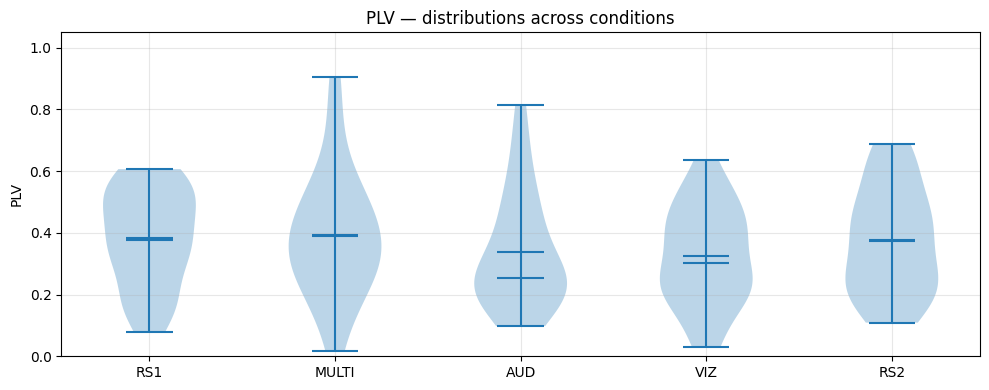

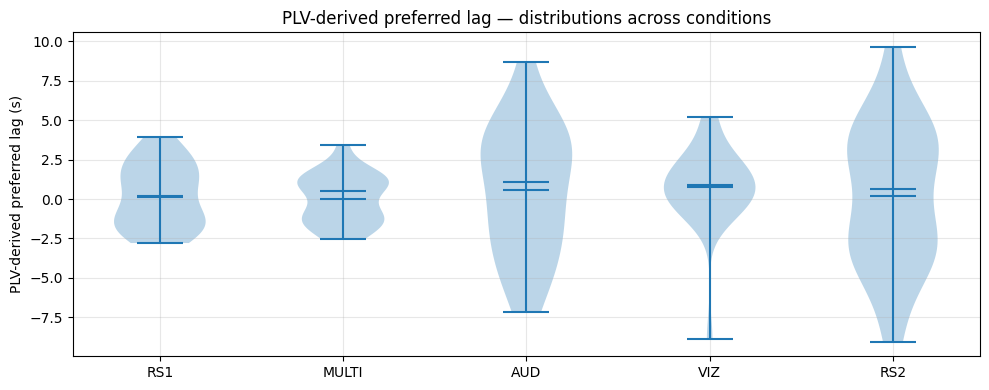

In [21]:
violin_xcorr_peak(sync_results)
violin_xcorr_lag(sync_results)
violin_coh_bandavg(sync_results)
violin_plv(sync_results)
violin_plv_lag(sync_results)
# optionally: violin_plv(sync_results, savepath="plv_violin.png")
